# Getfem++を使用した地盤の線形時刻歴応答解析

Getfem++を使用して地盤の２次元線形時刻歴応答解析を行いました。

In [1]:
import numpy as np
import getfem as gf
import pylab as plt
from scipy import io
from scipy.sparse import linalg 

## 解析条件

解析対象として、地震波S波速度2000m/secの地盤を考えます。

In [2]:
# S波速度(m/sec2)
Vs = 2.000e+03
# ポアソン比(-)
Nu =  4.800e-01
# 質量密度(kg/m3)
rho =  1.800e+01

# ラメの弾性定数
Mu =  rho*Vs**2
# ヤング率
E = Mu*(2*(1+Nu))
# ラメの弾性定数
Lambda = E*Nu/((1+Nu)*(1-2*Nu))
# P波速度(m/sec2)
Vp = np.sqrt((Lambda+2.000e+00*Mu)/rho)


対象領域は6000m×6000mの矩形領域とします。

In [3]:
d =  1.500e+02
x =  6.000e+03
z =  6.000e+03
m = gf.Mesh('cartesian', np.arange(0., x+d, d), np.arange(0., z+d, d))
m.set('optimize_structure')
m.export_to_pos("./pos/m.pos")
# 変位用オブジェクト
mfu = gf.MeshFem(m,2) 
mfu.set_fem(gf.Fem('FEM_QK(2,2)'))
# データ用オブジェクト
mfd = gf.MeshFem(m, 1) 
mfd.set_fem(gf.Fem('FEM_QK(2,1)'))

mim = gf.MeshIm(m, gf.Integ('IM_QUAD(3)'))


In [4]:
%%writefile gscript
Print "./png/m.png";
Exit;


Overwriting gscript


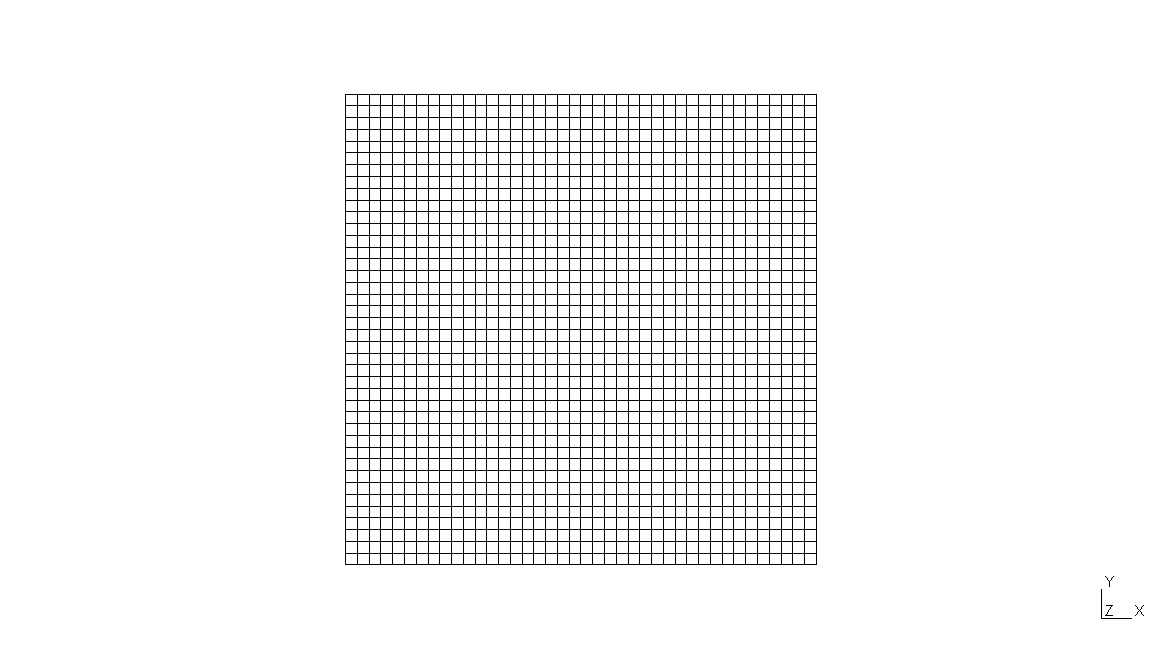

In [5]:
!gmsh ./pos/m.pos gscript
from IPython.core.display import Image
Image('./png/m.png')


境界条件は底面にインピーダンスを考慮したダンパー境界(水平方向$\rho V_S A$、上下方向$\rho V_P A$)を設け、側面部分には水平ローラーを設けます。ただし、$A$は各ダンパーの担当面積を意味します。
今回定義が必要な側面と底面について面を定義しておきます。

In [6]:
P = m.pts()
cbot = (abs(P[1,:]-0.000e+00) < 1.000e-6)
cright = (abs(P[0,:]-x) < 1.000e-6)
cleft = (abs(P[0,:]-0.000e+00) < 1.000e-6)

pidbot = np.compress(cbot,range(0,m.nbpts()))
pidright = np.compress(cright,range(0,m.nbpts()))
pidleft = np.compress(cleft,range(0,m.nbpts()))

fbot = m.faces_from_pid(pidbot)
fright = m.faces_from_pid(pidright)
fleft = m.faces_from_pid(pidleft)

BOTTOM = 1
RIGHT = 2
LEFT = 3
SIDE = 4
m.set_region(BOTTOM, fbot)
m.set_region(RIGHT,fright)
m.set_region(LEFT,fleft)

左右の水平ローラーを設定する際にはDirichlet条件$HU=R$の$H$と$R$を左右両端でそれぞれ求めそれを足し合わせます。

In [7]:
(H_LEFT,R_LEFT) = gf.asm_dirichlet(LEFT, mim, mfu, mfd, mfd.eval('[[0,0],[0,1]]'), mfd.eval('[0,0]'))
(H_RIGHT,R_RIGHT) = gf.asm_dirichlet(RIGHT, mim, mfu, mfd, mfd.eval('[[0,0],[0,1]]'), mfd.eval('[0,0]'))
H = H_LEFT+H_RIGHT
R = R_LEFT+R_RIGHT
(N,U0) = H.dirichlet_nullspace(R)

底面の粘性境界は外部粘性減衰としてNeumann条件から計算したものを減衰行列に足し合わせることにより考慮します。

In [8]:
nbd = mfd.nbdof()

C_BOTTOM = gf.asm_boundary_source(BOTTOM, mim, mfu, mfd, np.repeat([[rho*Vs], [rho*Vp]],nbd,1))
C_BOTTOM_X = gf.asm_boundary_source(BOTTOM, mim, mfu, mfd, np.repeat([[rho*Vs], [0]],nbd,1))

## 支配方程式
ここで、今回計算対象とする弾性体の支配方程式であるNavierの式をおさらいします。

$\left(\lambda+\mu\right)\dfrac{\partial}{\partial x}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{x}+f_{x}=\rho\dfrac{\partial^{2}u_{x}}{\partial t^{2}}$
$\left(\lambda+\mu\right)\dfrac{\partial}{\partial y}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{y}+f_{y}  =  \rho\dfrac{\partial^{2}u_{y}}{\partial t^{2}}$
$\left(\lambda+\mu\right)\dfrac{\partial}{\partial z}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{y}}{\partial y}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial y^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{z}+f_{z}  =  \rho\dfrac{\partial^{2}u_{z}}{\partial t^{2}}$

今回は２次元の解析ですので、Y方向の状態量は一定とします。($\dfrac{\partial}{\partial y}=0$)

$\left(\lambda+\mu\right)\dfrac{\partial}{\partial x}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{x}+f_{x}=\rho\dfrac{\partial^{2}u_{x}}{\partial t^{2}}$

$\left(\lambda+\mu\right)\dfrac{\partial}{\partial z}\left(\dfrac{\partial u_{x}}{\partial x}+\dfrac{\partial u_{z}}{\partial z}\right)+\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{z}+f_{z}=\rho\dfrac{\partial^{2}u_{z}}{\partial t^{2}}$

$\mu\left(\dfrac{\partial^{2}}{\partial x^{2}}+\dfrac{\partial^{2}}{\partial z^{2}}\right)u_{y}+f_{y}=\rho\dfrac{\partial^{2}u_{y}}{\partial t^{2}}$

上式の上２式は面内波の式、下の１式は面外波の式になります。今回はこの面外波の時刻歴応答解析を行います。下のように計算することで、剛性行列・質量行列・減衰行列を計算することができます。

In [9]:
# 剛性行列
K = gf.asm_linear_elasticity(mim, mfu, mfd, np.repeat([Lambda], nbd), np.repeat([Mu], nbd))
# 質量行列
M = gf.asm_mass_matrix(mim, mfu)*rho
# 減衰行列
C = gf.Spmat('copy',M)
C.clear()
C.set_diag((C_BOTTOM))
C_X = C_BOTTOM_X


なお、今回は面内波の計算のみを行いますが、$\lambda = -\mu$として入力を行えば、面外波の計算も可能です。現時点で、行列はGetfem++のSpmatオブジェクトになっていますが、これをMatrixMarketフォーマットでファイルに出力のうえ、Scipyのsparse matrixとして読み込みます。MatrixMarketは疎行列のメジャーなファイルフォーマットの１つです。

http://math.nist.gov/MatrixMarket/formats.html

In [10]:
N.save('mm', "N.mtx"); N = io.mmread("N.mtx")
K.save('mm', "K.mtx"); K = io.mmread("K.mtx")
M.save('mm', "M.mtx"); M = io.mmread("M.mtx")
C.save('mm', "C.mtx"); C = io.mmread("C.mtx")

In [11]:
# 側面の境界条件を考慮した行列
Nt = N.transpose()
KK = Nt*K*N
MM = Nt*M*N
CC = Nt*C*N
CC_X = Nt*C_X

下部の粘性境界からの入力速度波形としてRickerWaveletを使用します。

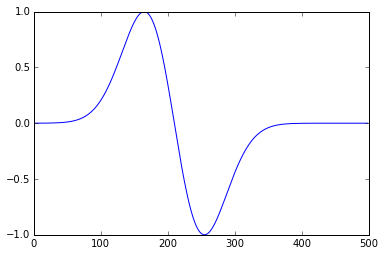

In [12]:
TP = 200
VP = 1.0
time_step = 500
wave = np.zeros(time_step)
time = np.arange(TP*2)
omegaP = 2.000E+00*np.pi/TP
tauR = omegaP/np.sqrt(2.0)*(time-TP)
wave[10+time] =  -np.sqrt(np.e)*tauR*VP*np.exp(-tauR**2/2.000E+00)
%matplotlib inline
plt.plot(wave)
plt.show()

# Newmark-β法による時刻歴応答解析

以上で、時刻歴応答解析に必要な質量行列・剛性行列・減衰行列および入力地震動が揃いました。これらを使用してNewmark-β法で時刻歴応答解析を行います。

In [13]:
# βの値
beta = 1./ 4.
# 時間刻み
dt = 0.01

sl = gf.Slice(('none',), mfu, 2)
MMM = MM+dt/2.000e+00*CC+beta*dt**2*KK

dis = np.zeros(CC_X.size)
vel = np.zeros(CC_X.size)
acc = np.zeros(CC_X.size)


In [14]:
for stpot in np.arange(1,time_step):

  dis0 = dis
  vel0 = vel
  acc0 = acc

  FFF = -CC*(vel0+dt/2.000e+00*acc0)-KK*(dis0+vel0*dt+(1.000e+00/2.000e+00-beta)*acc0*dt**2)-CC_X*wave[stpot]
  

  acc = linalg.spsolve(MMM, FFF)
  dis = dis0+vel0*dt+(1.000e+00/2.000e+00-beta)*acc0*dt**2+beta*acc*dt**2
  vel = vel0+1.000e+00/2.000e+00*(acc0+acc)*dt

  filename = 'results/linear-dynamic-'+("00000"+str(stpot))[-5:]+'.vtk'

  sl.export_to_vtk(filename, 'ascii', mfu, N*dis, 'Displacement', mfu, N*vel, 'Velocity', mfu, N*acc, 'Acceralation')